In [14]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

from sklearn.model_selection import train_test_split
from src.load_data import read_reviews, read_books, clean_books, clean_reviews, scale_data, review_map_id

### Load review data

In [2]:
reviews_df = read_reviews(os.path.join('data/', 'goodreads_reviews_mystery_thriller_crime.json.gz'))

counting file: data/goodreads_reviews_mystery_thriller_crime.json.gz
current line: 0,1000000,complete
done!


In [3]:
cleaned_reviews = clean_reviews(reviews_df)

/Users/elainewu/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
len(cleaned_reviews)

1791517

In [4]:
len(cleaned_reviews.book_id.unique()), len(cleaned_reviews.user_id.unique())

(214260, 199757)

#### delete users with only one rating

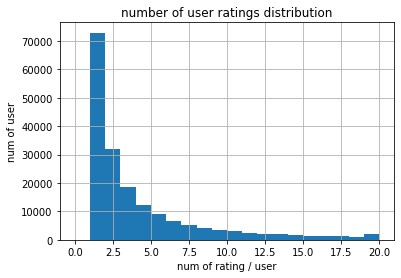

In [24]:
cleaned_reviews['user_id'].value_counts().reset_index()['user_id'].hist(range=(0,20), bins=20)
plt.title('number of user ratings distribution')
plt.xlabel('num of rating / user')
plt.ylabel('num of user');

In [14]:
mask = cleaned_reviews.groupby('user_id').count()['rating'] > 1

In [18]:
keep_users= cleaned_reviews.groupby('user_id').count()['rating'][mask]
len(keep_users.index)

126860

In [19]:
keep_user_ids = keep_users.index

In [20]:
cleaned_reviews1 = cleaned_reviews[cleaned_reviews.user_id.isin(keep_user_ids)]

#### delete books with only one rating

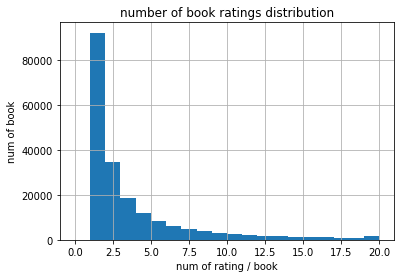

In [25]:
cleaned_reviews1['book_id'].value_counts().reset_index()['book_id'].hist(range=(0,20), bins=20)
plt.title('number of book ratings distribution')
plt.xlabel('num of rating / book')
plt.ylabel('num of book');

In [26]:
mask_book = cleaned_reviews1.groupby('book_id').count()['rating'] > 1
keep_books= cleaned_reviews1.groupby('book_id').count()['rating'][mask_book]
len(keep_books.index)

119615

In [27]:
keep_book_ids = keep_books.index
cleaned_reviews2 = cleaned_reviews1[cleaned_reviews1.book_id.isin(keep_book_ids)]

#### plot after delete user or book with only one rating

In [28]:
len(cleaned_reviews2.book_id.unique()), len(cleaned_reviews2.user_id.unique())

(119615, 126618)

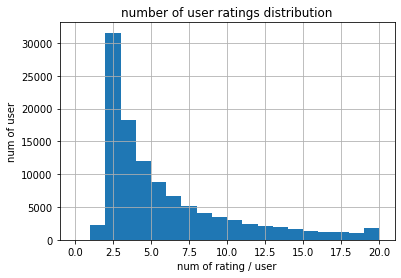

In [29]:
cleaned_reviews2['user_id'].value_counts().reset_index()['user_id'].hist(range=(0,20), bins=20)
plt.title('number of user ratings distribution')
plt.xlabel('num of rating / user')
plt.ylabel('num of user');

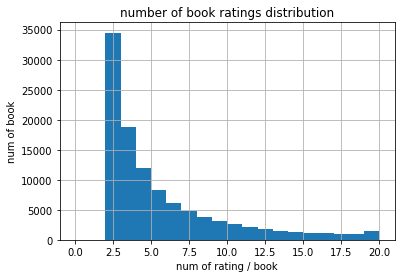

In [30]:
cleaned_reviews2['book_id'].value_counts().reset_index()['book_id'].hist(range=(0,20), bins=20)
plt.title('number of book ratings distribution')
plt.xlabel('num of rating / book')
plt.ylabel('num of book');

### Load book data

In [31]:
books_df = read_books(os.path.join('data/', 'goodreads_books_mystery_thriller_crime.json.gz'), head=False)

counting file: data/goodreads_books_mystery_thriller_crime.json.gz
current line: 0,complete
done!


In [32]:
books_df1 = books_df.copy()

In [33]:
cleaned_books = clean_books(books_df1)

In [34]:
len(cleaned_books)

182904

### book ids that are english and have non-zero ratings

In [35]:
#books in english
book_ids = cleaned_books.index.values
book_ids.shape

(182904,)

In [36]:
# books that have non-zero ratings
book_in_reviews = cleaned_reviews2.book_id.unique()
book_in_reviews.shape

(119615,)

In [37]:
#get the ids for books that are in english and have non zero ratings
total_book = np.intersect1d(book_ids, book_in_reviews)
len(total_book)

105365

In [38]:
# final clean book data
cleaned_books1 = cleaned_books.loc[total_book]
len(cleaned_books1)

105365

In [39]:
# final clean review data
cleaned_reviews3 = cleaned_reviews2[cleaned_reviews2.book_id.isin(total_book)]

In [40]:
len(cleaned_reviews3.book_id.unique()), len(cleaned_reviews3.user_id.unique())

(105365, 121333)

In [41]:
# remap the user id and book id for matrix factorization
cleaned_reviews4 = review_map_id(cleaned_reviews3).copy()

/Users/elainewu/Documents/Projects/Assignments/Capstone/Capstone Three/GoodRead Recommender/src/clean_data.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['old_user_id'] = df['user_id']
/Users/elainewu/Documents/Projects/Assignments/Capstone/Capstone Three/GoodRead Recommender/src/clean_data.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_id'] = map_id(df['old_user_id'])
/Users/elainewu/Documents/Projects/Assignments/Capstone/Capstone Three/GoodRead Recommender/src/clean_data.py:93: Sett

In [42]:
cleaned_reviews4.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
620327,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
620326,c7613da4cbd48baa83efec99b4dd6a41,102489,96299,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030
620325,469b9d160ad68ce84b6cac4585fb226a,102489,82887,4,2001-01-25 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,442783
620324,9f4fd2c20177f66fe5832ec299fb4bbf,102489,85615,2,2001-01-29 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,552719
620323,0c7a29c98c4f11b409235d9c22a2455b,102489,50050,4,2001-02-02 00:00:00,1,0,d889b42d9eb7b80e02f24830e27c6389,238117


### save the cleaned books and reviews

In [43]:
cleaned_books1.to_csv('data/cleaned_wo_one_rating_books_mystery.csv', header=cleaned_books1.columns)

In [44]:
cleaned_reviews4.to_csv('data/cleaned_wo_one_rating_reviews_mystery.csv',
                        header=cleaned_reviews4.columns, index=False)